<a href="https://colab.research.google.com/github/james-sheridan-code/SOLUSD/blob/main/Final_USDSOL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import yfinance as yf
import pandas as pd
import numpy as np
from hmmlearn.hmm import GaussianHMM
from xgboost import XGBClassifier, plot_importance # Added XGBClassifier and plot_importance
from sklearn.metrics import accuracy_score # Added accuracy_score
import matplotlib.pyplot as plt # Added matplotlib
import shap # Added shap

def createVariables(df):
  df = df.copy()

  # add log returns to the table
  df['log_ret'] = np.log(df['Close'] / df['Close'].shift(1))

  # add 20-day rolling standard deviation of returns to table
  df['volatility'] = df['log_ret'].rolling(window=20).std()

  # add spread between 200 and 50 moving averages to the table
  df['ma_50'] = df['Close'].rolling(50).mean()
  df['ma_200'] = df['Close'].rolling(200).mean()
  df['trend_spread'] = (df['ma_50'] - df['ma_200']) / df['ma_200']

  # add the rsi to the table
  delta = df['Close'].diff()
  gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
  loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
  rs = gain / loss
  df['rsi'] = 100 - (100 / (1 + rs))

  # clean table due to MAs
  df.dropna(inplace=True)

  # add Hidden Markov Model to table (Volatility and Returns as inputs)
  hmm_model = GaussianHMM(n_components=3, covariance_type="diag", n_iter=1000)
  features_hmm = df[['log_ret', 'volatility']].values
  hmm_model.fit(features_hmm)
  df['regime'] = hmm_model.predict(features_hmm)

  # adding target to the table (1 if price goes UP tomorrow, 0 if it goes DOWN)
  df['target'] = (df['log_ret'].shift(-1) > 0).astype(int)
  df.dropna(inplace=True) # Remove the last row which has no 'tomorrow'
  return df

def splitTable(df):
  split = int(len(df) * 0.8)
  train_df = df.iloc[:split]
  test_df = df.iloc[split:]
  return train_df, test_df

def trainModel(train_df, test_df, learnRate = 0.05, maxDepth = 3):
  # Define the features we want the model to learn from
  features = ['log_ret', 'volatility', 'trend_spread', 'rsi', 'regime']

  X_train = train_df[features]
  y_train = train_df['target']
  X_test = test_df[features]
  y_test = test_df['target']

  # Initialize the "Detective" (XGBoost)
  model = XGBClassifier(
      n_estimators=100,
      max_depth=maxDepth,
      learning_rate=learnRate,
      subsample=0.8,
      colsample_bytree=0.8,
      random_state=42
  )

  # Train the model
  model.fit(X_train, y_train)
  return model, X_train, y_train, X_test, y_test

def evaluateModel(model, test_df, X_test, y_test, risk_free_rate = 0.0, fee_rate = 0.001, learning_rate = 0.05):
  # Predict the direction for the test set
  y_pred = model.predict(X_test)

  # Check the accuracy
  accuracy = accuracy_score(y_test, y_pred)
  print(f"Model Accuracy: {accuracy:.2%}")

  # Feature Importance (XGBoost's plot_importance)
  plot_importance(model, importance_type='weight')
  plt.title("Weight: How many times was it used?")
  plt.show()

  plot_importance(model, importance_type='gain')
  plt.title("Gain: How much error did it actually fix?")
  plt.show()

  # Model Explainability (SHAP)
  explainer = shap.TreeExplainer(model)
  shap_values = explainer.shap_values(X_test)
  shap.summary_plot(shap_values, X_test)
  plt.show()

  # --- STRATEGY RETURNS & FEES ---
  test_df_copy = test_df.copy() # Make a copy to avoid SettingWithCopyWarning
  test_df_copy['prediction'] = y_pred

  # Calculate "Turnover" (Detects changes: 0->1 or 1->0)
  test_df_copy['turnover'] = test_df_copy['prediction'].diff().abs().fillna(0)
  # Ensure the very first trade is counted as turnover
  test_df_copy.iloc[0, test_df_copy.columns.get_loc('turnover')] = test_df_copy.iloc[0]['prediction']

  # Calculate Gross Returns (The market move)
  test_df_copy['strategy_returns'] = test_df_copy['prediction'] * test_df_copy['log_ret'].shift(-1)

  # Calculate Net Returns (The "Take-Home" profit)
  test_df_copy['fees'] = test_df_copy['turnover'] * fee_rate
  test_df_copy['net_ret'] = test_df_copy['strategy_returns'] - test_df_copy['fees']

  # --- CUMULATIVE CALCULATIONS ---
  test_df_copy['cum_market_returns'] = test_df_copy['log_ret'].shift(-1).cumsum().apply(np.exp)
  test_df_copy['cum_strategy_net'] = test_df_copy['net_ret'].cumsum().apply(np.exp)

  # Plot the results
  plt.figure(figsize=(12,6))
  plt.plot(test_df_copy['cum_market_returns'], label='Buy & Hold SOL', color='gray', alpha=0.5)
  plt.plot(test_df_copy['cum_strategy_net'], label='XGBoost Strategy (Net of Fees)', color='green', linewidth=2)
  plt.title("Institutional Backtest: Net Performance vs. Market")
  plt.ylabel("Growth of $1")
  plt.legend()
  plt.grid(True, alpha=0.3)
  plt.show()

  # --- THE METRICS SCORECARD ---
  metrics = calculate_metrics(test_df_copy, risk_free_rate)
  print("\n--- PERFORMANCE SCORECARD ---")
  for k, v in metrics.items():
      print(f"{k:25}: {v}")
  metrics_series = pd.Series(metrics)
  metrics_series['Learning Rate'] = learning_rate

  return metrics_series

def calculate_metrics(df, risk_free_rate=0.0):
    # Ensure we drop NaNs caused by the shift(-1)
    clean_df = df.dropna(subset=['net_ret']).copy()

    # 1. Annualized Returns
    total_net_log_return = clean_df['net_ret'].sum()
    days = len(clean_df)
    annualized_return = (total_net_log_return / days) * 365

    # 2. Sharpe Ratio (Annualized)
    daily_std = clean_df['net_ret'].std()
    sharpe = (annualized_return - risk_free_rate) / (daily_std * np.sqrt(365)) if daily_std != 0 else 0

    # 3. Sortino Ratio (Downside Risk only)
    downside_rets = clean_df[clean_df['net_ret'] < 0]['net_ret']
    downside_std = downside_rets.std() * np.sqrt(365)
    sortino = (annualized_return - risk_free_rate) / downside_std if downside_std != 0 else 0

    # 4. Max Drawdown
    cum_wealth = clean_df['net_ret'].cumsum().apply(np.exp)
    running_max = cum_wealth.cummax()
    drawdown = (cum_wealth - running_max) / running_max
    max_drawdown = drawdown.min()

    # 5. Profit Factor
    gross_profits = clean_df[clean_df['net_ret'] > 0]['net_ret'].sum()
    gross_losses = abs(clean_df[clean_df['net_ret'] < 0]['net_ret'].sum())
    profit_factor = gross_profits / gross_losses if gross_losses != 0 else np.inf

    return {
        "Annualized Net Return": f"{annualized_return:.2%}",
        "Sharpe Ratio": round(sharpe, 2),
        "Sortino Ratio": round(sortino, 2),
        "Max Drawdown": f"{max_drawdown:.2%}",
        "Profit Factor": round(profit_factor, 2),
        "Total Fees Paid": f"{clean_df['fees'].sum():.4%}"
    }

In [13]:
# GET DATA IN A TABLE

!pip install yfinance pandas numpy matplotlib xgboost hmmlearn

import yfinance as yf
import pandas as pd
import numpy as np
from hmmlearn.hmm import GaussianHMM

# Use 'SOL-USD' for Solana
df = yf.download('SOL-USD', start='2023-01-01', interval='1d')
df.columns = df.columns.get_level_values(0) # Clean multi-index if needed

# Display DataFrame summary and head as requested
print("\n--- DataFrame Info ---")
df.info()
print("\n--- DataFrame Head ---")
display(df.head())

# Call the functions to run the workflow

# 1. Create variables and prepare the data
df_processed = createVariables(df.copy())

# Perform the initial split for plotting and later use in the experiment
train_df, test_df = splitTable(df_processed)

# Define the learning rates for the experiment
learning_rates = np.arange(0.01, 0.405, 0.005).round(3).tolist()

# Run the hyperparameter experiment
hyperparam_results_df = run_hyperparameter_experiment(df_processed, learning_rates)

# Display the results DataFrame
print("\n--- Hyperparameter Tuning Results ---")
print(hyperparam_results_df)

# Save the results to a CSV file
output_csv_path = 'hyperparameter_metrics.csv'
hyperparam_results_df.to_csv(output_csv_path, index=False)
print(f"Hyperparameter tuning results saved to '{output_csv_path}'.")

print("\nWorkflow completed. Model performance metrics for each learning rate are displayed above and saved to CSV.")

/tmp/ipython-input-3700393571.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('SOL-USD', start='2023-01-01', interval='1d')
[*********************100%***********************]  1 of 1 completed


--- DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1113 entries, 2023-01-01 to 2026-01-17
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1113 non-null   float64
 1   High    1113 non-null   float64
 2   Low     1113 non-null   float64
 3   Open    1113 non-null   float64
 4   Volume  1113 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 52.2 KB

--- DataFrame Head ---


Price,Close,High,Low,Open,Volume
Date,,,,,
2023-01-01,9.982173,10.052801,9.721011,9.961036,194221164
2023-01-02,11.272967,11.372013,9.845211,9.983222,558570124
2023-01-03,13.344046,13.500268,11.053267,11.274727,1149255381
2023-01-04,13.435113,14.095340,12.922946,13.351509,1142852070
2023-01-05,13.419330,13.769200,12.990192,13.434939,564255825


NameError: name 'run_hyperparameter_experiment' is not defined

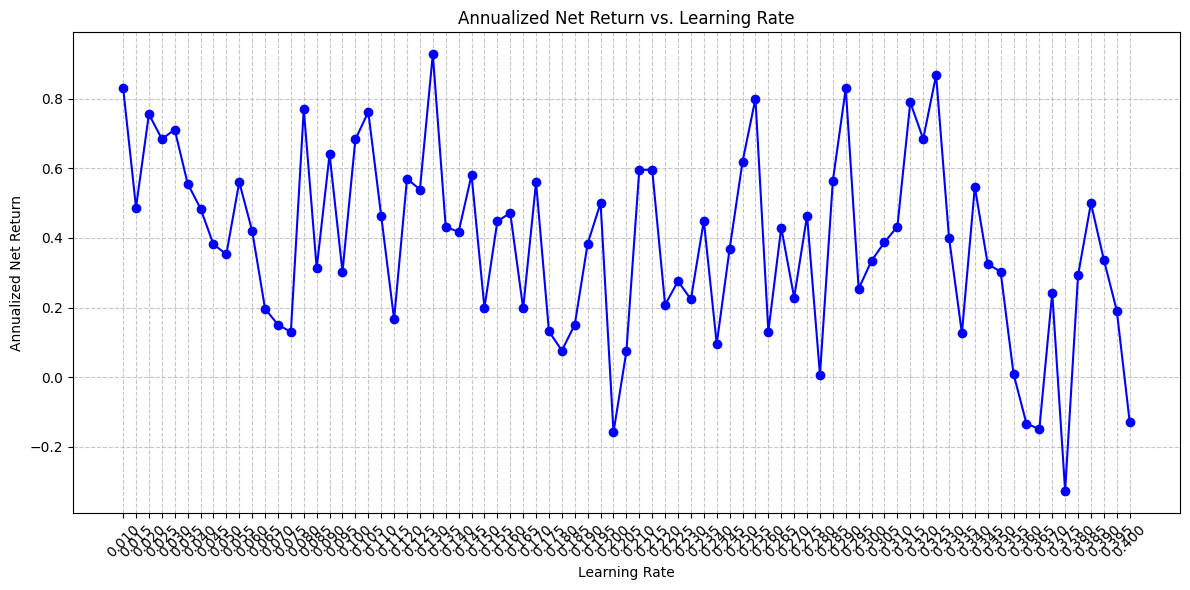

In [25]:
# Ensure 'Annualized Net Return' is a numeric type for plotting
hyperparam_results_df['Annualized Net Return'] = hyperparam_results_df['Annualized Net Return'].str.replace('%', '').astype(float) / 100

plt.figure(figsize=(12, 6))
plt.plot(hyperparam_results_df['Learning Rate'], hyperparam_results_df['Annualized Net Return'], marker='o', linestyle='-', color='blue')
plt.title('Annualized Net Return vs. Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Annualized Net Return')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(hyperparam_results_df['Learning Rate'], rotation=45)
plt.tight_layout()
plt.show()

In [4]:
# The content of this cell has been moved to cell fdZFdLCIZdgR to ensure df is in scope.